In [6]:
import os
import shutil

folder_path = '/content/fast-ALO'  # Replace 'my_folder' with the path to your directory

if os.path.exists(folder_path):
    shutil.rmtree(folder_path)
    print("Folder removed successfully")
else:
    print("Folder does not exist")


Folder removed successfully


In [1]:
import os
import shutil

!git clone https://github.com/RahnamaRad/fast-ALO

# Change the current directory to the cloned repository
os.chdir('fast-ALO')

Cloning into 'fast-ALO'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 5), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (14/14), 2.06 MiB | 5.86 MiB/s, done.
Resolving deltas: 100% (5/5), done.


Files loaded successfully.
Mean of log of factorial of r: 0.37222185037809974
Number of unique pairs: 3337
Proportion of space sampled: 0.3337
Sample size: 6265
Feature size: 10000


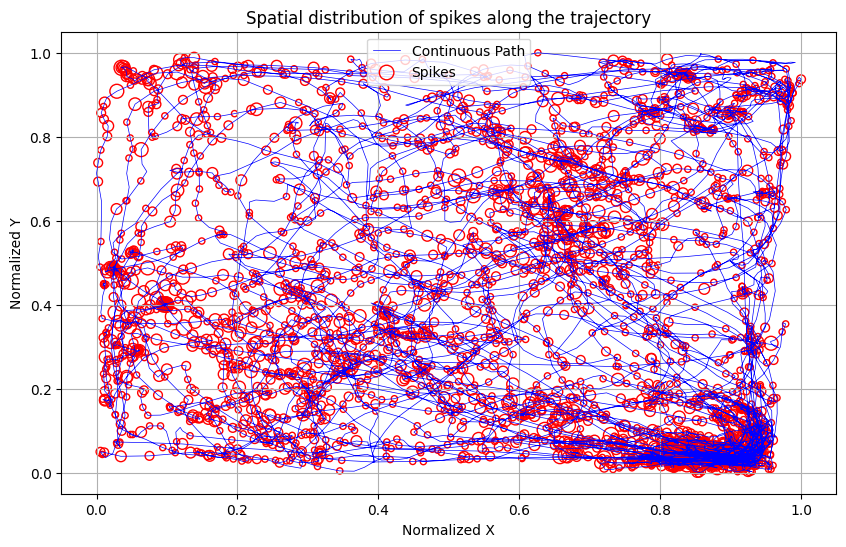

In [2]:
import numpy as np
import scipy.io
from scipy.interpolate import interp1d
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, csr_matrix

# Load the MATLAB files
cellName = 'T9C3'
formatSpec = f'BEN_{cellName}.mat'
pos_data_path = 'BEN_pos.mat'


data = scipy.io.loadmat(formatSpec)
pos_data = scipy.io.loadmat(pos_data_path)
print("Files loaded successfully.")

# Extract data from structures as needed, e.g.,
post = pos_data['post'].flatten()
posx = pos_data['posx'].flatten()
posy = pos_data['posy'].flatten()
cellTS = data['cellTS'].flatten()

# Filter spikes beyond the last recorded location time
cellTS = cellTS[cellTS < np.max(post)]

# Interpolation setup
dt = 0.2
time = np.arange(np.min(post), np.max(post), dt)
interp_x = interp1d(post, posx, kind='linear', fill_value='extrapolate')
interp_y = interp1d(post, posy, kind='linear', fill_value='extrapolate')

x_ = interp_x(time)
y_ = interp_y(time)

# Normalization
x_ = (x_ - np.min(x_)) / (np.max(x_) - np.min(x_))
y_ = (y_ - np.min(y_)) / (np.max(y_) - np.min(y_))

# Discretize
n = int(np.ceil(500 * dt))
x = np.ceil(x_ * n).astype(int)
y = np.ceil(y_ * n).astype(int)
x = np.clip(x, 1, n) - 1
y = np.clip(y, 1, n) - 1

# Time bins for spikes
T = len(time)
spike_bins = np.ceil((dt + cellTS - np.min(post)) / dt).astype(int)
spike_bins = np.clip(spike_bins, 1, T)

# Spike count per time bin
r = np.zeros(T)
for l in spike_bins - 1:
    r[l] += 1

# Calculation for mean_log_fac
mean_log_fac = np.mean(np.log(factorial(r)))
# Output a variable to check
print("Mean of log of factorial of r:", mean_log_fac)
# Assuming initialization of T, n, x, y, r
I = np.zeros(T, dtype=int)
R = np.zeros((n, n))
rows = []
cols = []
data = []
# Use a set to store unique pairs
unique_pairs = set()

# Calculate indices and update R
for t in range(T):
    I[t] = x[t] * n + n - 1 - y[t]
    R[n - y[t] - 1, x[t]] += r[t]
    rows.append(t)
    cols.append(I[t])
    data.append(1)  # You're setting this to 1, adjust if different values are needed
    # Add each pair to the set (automatically handles uniqueness)
    unique_pairs.add((x[t], y[t]))

# The number of unique pairs
number_of_unique_pairs = len(unique_pairs)

print("Number of unique pairs:", number_of_unique_pairs)
print("Proportion of space sampled:", number_of_unique_pairs / (n * n))
print("Sample size:", T)
print("Feature size:", n * n)

# Create the sparse matrix from the collected data
X = csr_matrix((data, (rows, cols)), shape=(T, n * n))

# Efficient computation of X^T * X
XTX = X.transpose().dot(X)

m = 2 * n * (n - 1)  # Total number of edges in an n x n grid

# Initialize D as a lil_matrix for incremental construction
D = lil_matrix((m, n**2))

current_row = 0

# Populate the matrix
for i in range(n):
    for j in range(n):
        index = i * n + j  # Current node index (row-major order)
        # Right neighbor
        if j < n - 1:
          right_index = index + 1
          D[current_row, index] = 1
          D[current_row, right_index] = -1
          current_row += 1
        # Down neighbor
        if i < n - 1:
          down_index = index + n
          D[current_row, index] = 1
          D[current_row, down_index] = -1
          current_row += 1

# Convert to csr_matrix for efficient operations
D = D.tocsr()
# Print the matrix to see its structure
#print(D_csr)
#print(XTX)  # This will display the sparse matrix format

# Create the plot
plt.figure(figsize=(10, 6))

# Plot the continuous path with a thinner blue line
plt.plot(x_, y_, 'b-', label='Continuous Path', linewidth=0.5)  # Thinner blue line

# Add red circles for spikes
spike_indices = np.where(r > 0)[0]
# Scale the sizes of the circles based on the spike counts, multiplying by a factor for visibility
sizes = r[spike_indices] * 20  # Scale factor can be adjusted as needed
plt.scatter(x_[spike_indices], y_[spike_indices], facecolors='none', edgecolors='r', s=sizes, label='Spikes')

# Adding labels and legend
plt.title('Spatial distribution of spikes along the trajectory')
plt.xlabel('Normalized X')
plt.ylabel('Normalized Y')
plt.legend()
plt.grid(True)  # Adds a grid for easier visualization

# Display the plot
plt.show()

# Save the plot image as PNG
#plot_filename = 'spatial_distribution_of_spikes.png'
#plt.savefig(plot_filename, format='png')

# Alternatively, you can try saving it in a different format like JPEG or PDF
#plt.savefig('spatial_distribution_of_spikes.jpg', format='jpg')
#plt.savefig('spatial_distribution_of_spikes.pdf', format='pdf')




In [4]:
import numpy as np
import pandas as pd

# Assuming R and I are already defined as per your earlier script

# Save R array to CSV
np.savetxt("R_matrix.csv", R, delimiter=",", fmt='%d')  # Assuming R contains integer data

# Save I array to CSV
np.savetxt("I_vector.csv", I, delimiter=",", fmt='%d')  # Assuming I contains integer data

print("Files saved: R_matrix.csv and I_vector.csv")


Files saved: R_matrix.csv and I_vector.csv


In [ ]:
# Read the CSV files back into numpy arrays
R_loaded = np.loadtxt("R_matrix.csv", delimiter=",", dtype=int)
I_loaded = np.loadtxt("I_vector.csv", delimiter=",", dtype=int)

# Convert numpy arrays to pandas DataFrame for better handling and visualization
R_df = pd.DataFrame(R_loaded)
I_df = pd.DataFrame(I_loaded, columns=['Index'])

print("Data loaded into DataFrames.")
print("R matrix:")
print(R_df.head())  # Display the first few rows of the R DataFrame
print("I vector:")
print(I_df.head())  # Display the first few rows of the I DataFrame


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import cg, LinearOperator, inv
from time import time  # Make sure to import the time function
np.random.seed(0)  # Setting seed for reproducibility
# Tolerance and maximum iterations
tol = 1e-3
maxiter = 100
lm = 10
n2 = n * n


lambdas = np.logspace(0, 2, lm)[::-1] # Array of lambda values from 1 to 0.1 in descending order

# Define the matrix-vector product function outside the loop
def matvec(v, lambda_reg):
    return X.T @ (X @ v) + lambda_reg * (D.T @ (D @ v))

# Vectors of zeros
ALO       = []  # Creates a column vector of zeros of length m
ALO_fast  = []   # Same as above
TRAIN     = []  # Same as above
timeALO       = [] # Creates a column vector of zeros of length m
timeALO_fast  = []   # Same as above
timeTRAIN     = []  # Same as above





# Right-hand side of the equation
b = X.T @ r
# Compute sum(X.T), which is equivalent to summing each row of X
sum_X_T = np.sum(X.T, axis=1).A.flatten()  # Using .A to convert to dense array and flatten to make 1D

# Compute (b+0.5) / (sum(X.T) + 0.5)
z = (b + 0.5) / (sum_X_T + 0.5)
S = 250  # Number of iterations/samples
# Arrays to store results
b_s1 = np.zeros((n2, S))  # to store results of X.T @ e_s1
b_s2 = np.zeros((n2, S))  # to store results of D.T @ e_s2
u_s  = np.zeros((n2, S))
Hii  = np.zeros((n2, lm))
Hii_fast  = np.zeros((n2, lm))

lmi = 0

for s in range(S):
    # Sample e_s1, e_s2 from N(0, I)
    e_s1 = np.random.normal(0, 1, T)
    e_s2 = np.random.normal(0, 1, m)
    # Compute b_s1 and b_s2
    b_s1[:, s] = X.T @ e_s1  # Compute X^T @ e_s1
    b_s2[:, s] = D.T @ e_s2  # Compute D^T @ e_s2
    # Optional: Print out the results to check
    #print("b_s1 results:\n", b_s1)
    #print("b_s2 results:\n", b_s2)

# Loop over different lambda values
for lambda_reg in lambdas:
    # Define shape of A for the LinearOperator with the current lambda
    n2 = X.shape[1]
    A = LinearOperator((n2, n2), matvec=lambda v: matvec(v, lambda_reg))
    # Start timing - TRAIN
    tstart = time()
    # Solve for y using conjugate gradient
    z, exit_code = cg(A, b, x0=z, tol=tol, maxiter=maxiter)
    # End timing
    fit_time = time() - tstart
    timeTRAIN.append(fit_time)  # Store the fitting time
    mse = np.mean((r - (X @ z))**2)
    TRAIN.append(mse)

    # Start timing - ALO
    tstart = time()
    diag_inv = np.zeros((n2,1))
    for i in range(n2):
        # Create the i-th unit vector in sparse format
        e_i = csr_matrix((np.array([1]), ([i], [0])), shape=(n2,1))
        e_i = e_i.toarray().ravel()
        # Solve A x = e_i
        # Since e_i is a 1xN matrix, we need to flatten it to make it a proper vector
        ae, exit_code = cg(A, e_i, tol=tol, maxiter=maxiter)
        if exit_code == 0:
            # The i-th diagonal element of A^{-1} is the i-th element of ae
            diag_inv[i] = ae[i]
            e = A @ ae
            #if (np.sum(abs(A @ ae- e_i)) > 0.001):
            #    print(np.sum(abs(A @ ae- e_i)))
        else:
            e=e
            #raise Exception(f"CG did not converge for the {i}-th unit vector")
    hh = np.zeros((T,1))
    for t in range(T):
        hh[t] = diag_inv[I[t]]
    # End timing
    alo_time = time() - tstart
    timeALO.append(alo_time)  # Store the fitting time
    alo     = np.mean(((r - (X @ z) ) / (1 - hh)) **2)
    ALO.append(alo)
    Hii[:, lmi] = diag_inv.flatten()

    # Start timing - fast ALO
    tstart = time()
    b_s = b_s1 +  np.sqrt(lambda_reg) * b_s2
    # Solve the system A x = b for each column of b_s
    for s in range(S):
        u_, info = cg(A, b_s[:, s], x0=u_s[:, s])
        if info == 0:
            u_s[:, s] = u_
        else:
            print(f"CG did not converge for column {s}")
    #XU = X @ u_s
    #Z =  (u_s @ u_s.T) / S
    # Step 1: Center the data
    means = np.mean(u_s, axis=1, keepdims=True)
    u_s_centered = u_s - means
    # Step 2: Compute the covariance matrix
    Z =  np.dot(u_s_centered, u_s_centered.T) / (S - 1)
    #for l in range(4):
     #   Z  = 2*Z - Z @ (A @ Z)
    diag_inv_ = Z.diagonal()
    Hii_fast[:, lmi] = diag_inv_
    Z  = (X @ Z) @ X.T
    hh_fast = np.diag(Z)

    #print(hh_fast)
    #np.var(XU, axis=1, ddof=1)  # ddof=1 uses (S-1) in the denominator
    # End timing
    alo_fast_time = time() - tstart
    timeALO_fast.append(alo_fast_time)  # Store the fitting time
    alo_fast     = np.mean(((r - (X @ z)) / (1 - hh_fast)) **2)
    ALO_fast.append(alo_fast)
    print(f"lambda = {lambda_reg:.2f}| alo={alo:.2f}| alo time ={alo_time:.0f}| alo_fast={alo_fast:.2f}| alo_fast time ={alo_fast_time:.0f}| mse={mse:.2f}| fit time = {fit_time:.2f}| h ={np.mean(hh):.2f}| max_err ={np.max(abs(diag_inv_ - diag_inv)):.2f}| mean_err ={np.mean(abs(diag_inv_ - diag_inv)):.2f}")
    lmi = lmi + 1

# Ensure all arrays are numpy arrays for easier handling
fit_times = np.array(timeTRAIN)
tt=np.mean(fit_times)


lambda = 100.00| alo=1.19| alo time =314| alo_fast=1.21| alo_fast time =16| mse=1.19| fit time = 0.12| h =0.00| max_err =0.02| mean_err =0.01
lambda = 59.95| alo=1.17| alo time =302| alo_fast=1.18| alo_fast time =12| mse=1.16| fit time = 0.04| h =0.01| max_err =0.04| mean_err =0.01
lambda = 35.94| alo=1.16| alo time =264| alo_fast=1.16| alo_fast time =10| mse=1.12| fit time = 0.02| h =0.01| max_err =0.06| mean_err =0.00
lambda = 21.54| alo=1.14| alo time =215| alo_fast=1.14| alo_fast time =9| mse=1.09| fit time = 0.02| h =0.02| max_err =0.09| mean_err =0.01
lambda = 12.92| alo=1.13| alo time =174| alo_fast=1.13| alo_fast time =8| mse=1.05| fit time = 0.02| h =0.03| max_err =0.14| mean_err =0.01
lambda = 7.74| alo=1.12| alo time =145| alo_fast=1.13| alo_fast time =7| mse=1.01| fit time = 0.01| h =0.05| max_err =0.22| mean_err =0.01
lambda = 4.64| alo=1.13| alo time =122| alo_fast=1.13| alo_fast time =8| mse=0.97| fit time = 0.02| h =0.07| max_err =0.36| mean_err =0.02
lambda = 2.78| alo

In [ ]:
print(hh.shape[0])
print(hh_fast.shape[0])
print(T)
print(m)
print(X.shape[0])
print(X.shape[1])
print(D.shape[0])
print(D.shape[1])
print(Z.shape[1])
print(Z.shape[0])
C=(u_s @ u_s.T) / S
print(S)
#print( np.sum(abs(A @ ae- e_i.toarray().ravel())))

print(I)


3133
3133
3133
4900
3133
2500
4900
2500
3133
3133
5000
[1826 1776 1827 ... 2347 2347 2347]


0.0
1912.3293430805206


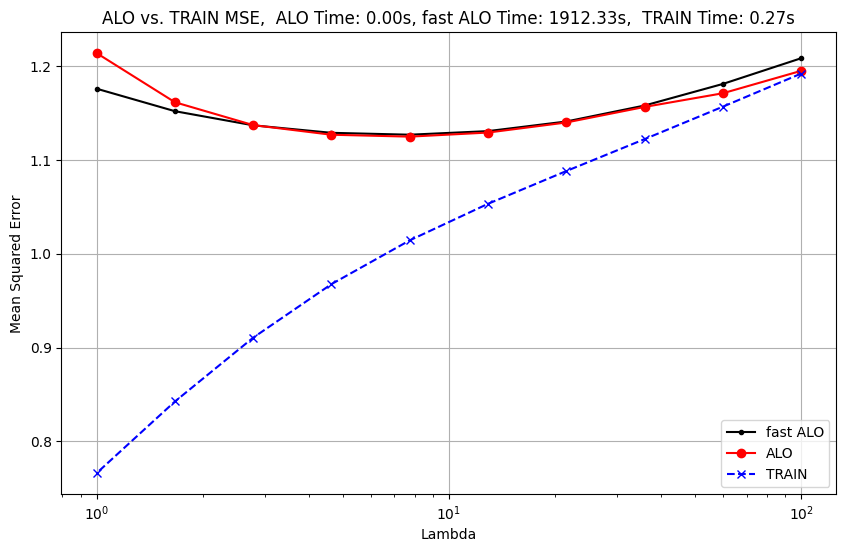

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure the lists are numpy arrays for easier manipulation
timeALO_fast = np.array(timeALO_fast)  # Make sure to use the correct time list for ALO
timeALO = np.array(timeALO)  # Make sure to use the correct time list for ALO
timeTRAIN = np.array(timeTRAIN)
ALO = np.array(ALO)
ALO_fast = np.array(ALO_fast)
TRAIN = np.array(TRAIN)
lambdas = np.array(lambdas)


# Summing the computation times
total_time_ALO = np.sum(timeALO)
total_time_ALO_fast = np.sum(timeALO_fast)
total_time_TRAIN = np.sum(timeTRAIN)
print(total_time_ALO )
print(total_time_ALO_fast)

# Plotting ALO and TRAIN MSE against lambdas
plt.figure(figsize=(10, 6))
plt.plot(lambdas, ALO_fast, marker='.', linestyle='-', color='black', label='fast ALO')
plt.plot(lambdas, ALO, marker='o', linestyle='-', color='red', label='ALO')
plt.plot(lambdas, TRAIN, marker='x', linestyle='--', color='blue', label='TRAIN')
plt.xscale('log')  # Since lambda values are log-spaced
plt.xlabel('Lambda')
plt.ylabel('Mean Squared Error')
plt.title(f'ALO vs. TRAIN MSE,  ALO Time: {total_time_ALO:.2f}s, fast ALO Time: {total_time_ALO_fast:.2f}s,  TRAIN Time: {total_time_TRAIN:.2f}s')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

import matplotlib.pyplot as plt

# Plotting the fitting times against lambda values
plt.figure(figsize=(10, 6))
plt.plot(lambdas, fit_times, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Since lambda values are log-spaced
plt.xlabel('Lambda')
plt.ylabel('Fitting Time (seconds)')
plt.title(f'Fitting Time vs. Lambda, t={tt:.4f}')
plt.grid(True)
plt.show()